<a href="https://colab.research.google.com/github/luciainnocenti/Homework3-PACS/blob/master/MLDL_Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm


from numpy import random 
import numpy as np

random.seed(33)

#**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [0]:
#V1

alfa = 1
LR = 1e-4

In [0]:
#V2

alfa = 1
LR = 1e-5

In [0]:
#V3

alfa = 0.1
LR = 1e-5

In [0]:
#V4, version with variable alfa

alfa = 0
LR = 1e-5
p = 0

# Import and definition

In [5]:
# Clone github repository with data
!git clone https://github.com/luciainnocenti/Homework3-PACS.git
!mv 'Homework3-PACS' 'HW_PACS'

from HW_PACS.dataset import PACS_Dataset 

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 10126 (delta 13), reused 0 (delta 0), pack-reused 10102
Receiving objects: 100% (10126/10126), 174.56 MiB | 34.53 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Checking out files: 100% (9995/9995), done.


In [4]:
## Define transforms for training phase
#transformer = transforms.Compose([transforms.Resize(256),   
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
#])
#rootPhoto = "HW_PACS/PACS/photo"
#photos = PACS_Dataset(root = rootPhoto, transform = transformer)
#
#rootArt_painting = "HW_PACS/PACS/art_painting"
#art_painting = PACS_Dataset(root = rootArt_painting, transform = transformer)
#
#photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#
#print(photos.meanAndStd(photos_dataloader))
#print(art_painting.meanAndStd(art_painting_dataloader))

(tensor([0.5088, 0.4744, 0.4307]), tensor([0.2725, 0.2620, 0.2774]))
(tensor([0.5530, 0.5018, 0.4488]), tensor([0.2750, 0.2648, 0.2775]))


#**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),   
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.5088, 0.4744, 0.4307), (0.2725, 0.2620, 0.2774)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the test phase
test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5530, 0.5018, 0.4488), (0.2750, 0.2648, 0.2775))                                    
])

#**Prepare Dataset**

In [7]:
rootPhoto = "HW_PACS/PACS/photo"
photos = PACS_Dataset(root = rootPhoto, transform = train_transform)

rootArt_painting = "HW_PACS/PACS/art_painting"
art_painting = PACS_Dataset(root = rootArt_painting, transform = test_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(photos)))
print('Test Dataset: {}'.format(len(art_painting)))

Train Dataset: 1670
Test Dataset: 2048


#**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#**Model without DANN**

##**Prepare Network**

In [9]:
from HW_PACS.gradient_reversal_example import alexNetDA 

net = alexNetDA(num_classes = 7)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


##**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() 

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum

#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

optimizer = optim.Adam(parameters_to_optimize, LR)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
running_corrects = 0
current_step = 0
# Start iterating over the epochs
# Iterate over the dataset
for epoch in range(NUM_EPOCHS):
  scheduler.step() 
  
  for images, labels in  tqdm(photos_dataloader):

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights

    loss.backward()  # backward pass: computes gradients

    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(photos))
  print("Accuracy on training set = "  + str(accuracy))
  running_corrects = 0
    

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  7%|▋         | 1/14 [00:02<00:33,  2.57s/it]

Step 0, Loss 2.042131185531616


 79%|███████▊  | 11/14 [00:06<00:01,  1.87it/s]

Step 10, Loss 1.24440336227417


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.43233532934131735


 57%|█████▋    | 8/14 [00:04<00:02,  2.49it/s]

Step 20, Loss 0.8165515661239624


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.7622754491017965


 29%|██▊       | 4/14 [00:02<00:08,  1.12it/s]

Step 30, Loss 0.6540982723236084


  0%|          | 0/14 [00:00<?, ?it/s]

Step 40, Loss 0.4705784022808075
Accuracy on training set = 0.8718562874251496


 64%|██████▍   | 9/14 [00:05<00:03,  1.62it/s]

Step 50, Loss 0.2878273129463196


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9143712574850299


 36%|███▌      | 5/14 [00:03<00:07,  1.13it/s]

Step 60, Loss 0.22943910956382751


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9353293413173652


  7%|▋         | 1/14 [00:02<00:27,  2.13s/it]

Step 70, Loss 0.24117569625377655


 86%|████████▌ | 12/14 [00:05<00:00,  2.92it/s]

Step 80, Loss 0.12767136096954346


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9497005988023952


 57%|█████▋    | 8/14 [00:04<00:02,  2.36it/s]

Step 90, Loss 0.18752214312553406


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9574850299401197


 29%|██▊       | 4/14 [00:02<00:08,  1.24it/s]

Step 100, Loss 0.08558423817157745


  0%|          | 0/14 [00:00<?, ?it/s]

Step 110, Loss 0.15462087094783783
Accuracy on training set = 0.9670658682634731


 71%|███████▏  | 10/14 [00:05<00:01,  2.11it/s]

Step 120, Loss 0.05653945356607437


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9748502994011976


 43%|████▎     | 6/14 [00:03<00:05,  1.50it/s]

Step 130, Loss 0.058150019496679306


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9802395209580839


  7%|▋         | 1/14 [00:02<00:27,  2.10s/it]

Step 140, Loss 0.08011823892593384


 86%|████████▌ | 12/14 [00:05<00:00,  2.58it/s]

Step 150, Loss 0.11385424435138702


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9808383233532935


 50%|█████     | 7/14 [00:04<00:03,  1.75it/s]

Step 160, Loss 0.07240451872348785


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.981437125748503


 21%|██▏       | 3/14 [00:02<00:13,  1.23s/it]

Step 170, Loss 0.04289756342768669


  0%|          | 0/14 [00:00<?, ?it/s]

Step 180, Loss 0.03637932613492012
Accuracy on training set = 0.9880239520958084


 64%|██████▍   | 9/14 [00:05<00:03,  1.66it/s]

Step 190, Loss 0.06909707933664322


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9892215568862276


 36%|███▌      | 5/14 [00:03<00:07,  1.22it/s]

Step 200, Loss 0.02197020687162876


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9940119760479041


  7%|▋         | 1/14 [00:02<00:28,  2.22s/it]

Step 210, Loss 0.02629712037742138


 79%|███████▊  | 11/14 [00:06<00:01,  2.25it/s]

Step 220, Loss 0.039608314633369446


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9892215568862276


 57%|█████▋    | 8/14 [00:04<00:02,  2.21it/s]

Step 230, Loss 0.029170595109462738


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9940119760479041


 21%|██▏       | 3/14 [00:02<00:12,  1.14s/it]

Step 240, Loss 0.03682701289653778


  0%|          | 0/14 [00:00<?, ?it/s]

Step 250, Loss 0.018611019477248192
Accuracy on training set = 0.9940119760479041


 64%|██████▍   | 9/14 [00:05<00:03,  1.59it/s]

Step 260, Loss 0.03742147237062454


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9946107784431137


 36%|███▌      | 5/14 [00:03<00:08,  1.06it/s]

Step 270, Loss 0.017462532967329025


100%|██████████| 14/14 [00:05<00:00,  2.37it/s]

Accuracy on training set = 0.9958083832335329


##**Test**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
losses = []
running_corrects = 0
for images, labels in tqdm(art_painting_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  loss = criterion(outputs, labels)
  losses.append(loss)
  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_painting))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:07<00:00,  2.26it/s]

Test Accuracy: 0.45751953125


In [13]:
loss.item()

6.667601585388184

# Model with DANN

## Network

In [0]:
net = alexNetDA(num_classes = 7)
net = net.to(DEVICE)

## Loss, Optim and Scheduler

In [0]:
criterion_class = nn.CrossEntropyLoss() 
criterion_domain = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters() 

#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(parameters_to_optimize, LR)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## Test function

In [0]:
def testFunction(datasetName, epoch):  
  net = torch.load('model_epoch_' + str(epoch) + '.pt')
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  if (datasetName == 'photo'):
    dataLoader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  elif( datasetName == 'artPainting'):
    dataLoader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  lenLoader = len(dataLoader)
  iterator = iter(dataLoader)
  totalLen = 0
  running_corrects = 0
  criterion = nn.CrossEntropyLoss() 
  for i in range(lenLoader):
    t_img, t_label = next(iterator)

    t_img = t_img.to(DEVICE)
    t_label = t_label.to(DEVICE)

    # Forward Pass
    classes_output = net(t_img)

    loss = criterion(classes_output, t_label)

    # Get predictions
    _, preds = torch.max(classes_output.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == t_label.data).data.item()
    totalLen += len(t_img)

  # Calculate Accuracy
  accuracy = running_corrects / float(totalLen)

  print(f'Accuracy on  {datasetName}' f' during epoch {epoch}' f' is {accuracy}' f' loss is {loss}')

## Train 

In [0]:
#photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

max_batches = max(len(photos_dataloader), len(art_painting_dataloader))
min_batches = min(len(photos_dataloader), len(art_painting_dataloader))

In [0]:
import matplotlib.pyplot as plt

def plotfunction(losses, alphas):
  losses_s_label = []
  losses_s_domain = []
  losses_t_domain = []

  for el in losses:
    losses_s_label.append(el[0])
    losses_s_domain.append(el[1])
    losses_t_domain.append(el[2])

  plt.plot(np.linspace(0,max_batches-1, max_batches), losses_s_label)
  plt.plot(np.linspace(0,max_batches-1, max_batches), losses_s_domain)
  plt.plot(np.linspace(0,max_batches-1, max_batches), losses_t_domain) 
  plt.plot(np.linspace(0,max_batches-1, max_batches), alphas)   
  plt.xlabel("Epoch")
  plt.legend(['losses_s_label', 'losses_s_domain', 'losses_t_domain', 'alphas'])
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1/16] class_loss: 1.9646 s_domain_loss: 0.9148 t_domain_loss: 0.5579 aplha: 0.0
[2/16] class_loss: 1.8871 s_domain_loss: 0.8839 t_domain_loss: 0.5671 aplha: 0.015623728558408878
[3/16] class_loss: 1.7967 s_domain_loss: 0.8624 t_domain_loss: 0.5878 aplha: 0.031239831446031152
[4/16] class_loss: 1.6482 s_domain_loss: 0.8263 t_domain_loss: 0.5853 aplha: 0.04684069787264811
[5/16] class_loss: 1.5899 s_domain_loss: 0.8199 t_domain_loss: 0.6019 aplha: 0.06241874674751258
[6/16] class_loss: 1.6164 s_domain_loss: 0.7902 t_domain_loss: 0.6182 aplha: 0.07796644137536823
[7/16] class_loss: 1.5156 s_domain_loss: 0.7741 t_domain_loss: 0.6312 aplha: 0.09347630396922768
[8/16] class_loss: 1.4039 s_domain_loss: 0.7420 t_domain_loss: 0.6472 aplha: 0.10894092992085458
[9/16] class_loss: 1.3795 s_domain_loss: 0.7415 t_domain_loss: 0.6560 aplha: 0.12435300177159614
[10/16] class_loss: 1.2926 s_domain_loss: 0.7340 t_domain_loss: 0.6692 aplha: 0.13970530282831417
[11/16] class_loss: 1.2477 s_domain_loss: 0

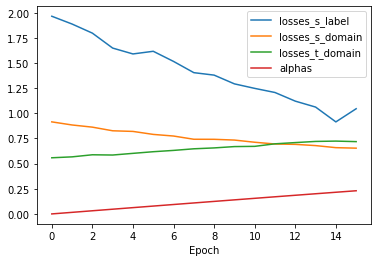

[1/16] class_loss: 0.9264 s_domain_loss: 0.6488 t_domain_loss: 0.7115 aplha: 0.2449186624037092
[2/16] class_loss: 0.8779 s_domain_loss: 0.6418 t_domain_loss: 0.7217 aplha: 0.25954921480882676
[3/16] class_loss: 0.7344 s_domain_loss: 0.6284 t_domain_loss: 0.7317 aplha: 0.27406158896076627
[4/16] class_loss: 0.7865 s_domain_loss: 0.6286 t_domain_loss: 0.7178 aplha: 0.2884502129727393
[5/16] class_loss: 0.8251 s_domain_loss: 0.6302 t_domain_loss: 0.7241 aplha: 0.3027097293321084
[6/16] class_loss: 0.8329 s_domain_loss: 0.6319 t_domain_loss: 0.7219 aplha: 0.31683500112336604
[7/16] class_loss: 0.6129 s_domain_loss: 0.6242 t_domain_loss: 0.7226 aplha: 0.33082111749362797
[8/16] class_loss: 0.6103 s_domain_loss: 0.6271 t_domain_loss: 0.7253 aplha: 0.34466339835857207
[9/16] class_loss: 0.6927 s_domain_loss: 0.6257 t_domain_loss: 0.7207 aplha: 0.35835739835078595
[10/16] class_loss: 0.6601 s_domain_loss: 0.6367 t_domain_loss: 0.7123 aplha: 0.371898910016385
[11/16] class_loss: 0.7044 s_domai

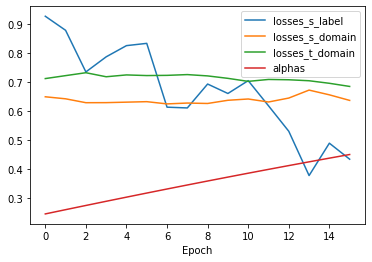

[1/16] class_loss: 0.5118 s_domain_loss: 0.6458 t_domain_loss: 0.6697 aplha: 0.4621171572600098
[2/16] class_loss: 0.4554 s_domain_loss: 0.6433 t_domain_loss: 0.6719 aplha: 0.4743163252573668
[3/16] class_loss: 0.4323 s_domain_loss: 0.6457 t_domain_loss: 0.6741 aplha: 0.4863360172249622
[4/16] class_loss: 0.4404 s_domain_loss: 0.6577 t_domain_loss: 0.6556 aplha: 0.49817442622945496
[5/16] class_loss: 0.3878 s_domain_loss: 0.6538 t_domain_loss: 0.6593 aplha: 0.5098299737352565
[6/16] class_loss: 0.4314 s_domain_loss: 0.6580 t_domain_loss: 0.6538 aplha: 0.5213013053545767
[7/16] class_loss: 0.3588 s_domain_loss: 0.6706 t_domain_loss: 0.6545 aplha: 0.5325872861719194
[8/16] class_loss: 0.3440 s_domain_loss: 0.6573 t_domain_loss: 0.6584 aplha: 0.5436869956781494
[9/16] class_loss: 0.3265 s_domain_loss: 0.6582 t_domain_loss: 0.6592 aplha: 0.5545997223493822
[10/16] class_loss: 0.2726 s_domain_loss: 0.6504 t_domain_loss: 0.6480 aplha: 0.5653249579058752
[11/16] class_loss: 0.3650 s_domain_lo

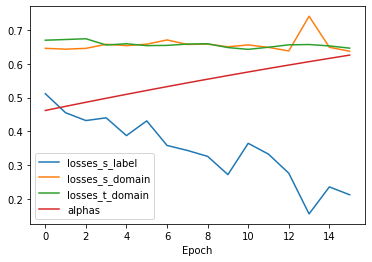

[1/16] class_loss: 0.3220 s_domain_loss: 0.6434 t_domain_loss: 0.6388 aplha: 0.6351489523872873
[2/16] class_loss: 0.2386 s_domain_loss: 0.6308 t_domain_loss: 0.6443 aplha: 0.6443782610439006
[3/16] class_loss: 0.2111 s_domain_loss: 0.6298 t_domain_loss: 0.6502 aplha: 0.6534235881413468
[4/16] class_loss: 0.2353 s_domain_loss: 0.6368 t_domain_loss: 0.6351 aplha: 0.6622860957166337
[5/16] class_loss: 0.2270 s_domain_loss: 0.6419 t_domain_loss: 0.6415 aplha: 0.6709670742068738
[6/16] class_loss: 0.2323 s_domain_loss: 0.6250 t_domain_loss: 0.6396 aplha: 0.6794679353444786
[7/16] class_loss: 0.1644 s_domain_loss: 0.6181 t_domain_loss: 0.6432 aplha: 0.6877902051090852
[8/16] class_loss: 0.2817 s_domain_loss: 0.6296 t_domain_loss: 0.6479 aplha: 0.6959355167556514
[9/16] class_loss: 0.2259 s_domain_loss: 0.6270 t_domain_loss: 0.6522 aplha: 0.7039056039366212
[10/16] class_loss: 0.2547 s_domain_loss: 0.6504 t_domain_loss: 0.6399 aplha: 0.7117022939345188
[11/16] class_loss: 0.2568 s_domain_los

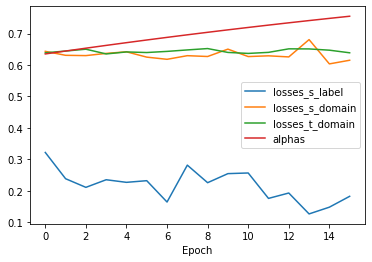

[1/16] class_loss: 0.1842 s_domain_loss: 0.5986 t_domain_loss: 0.6330 aplha: 0.7615941559557646
[2/16] class_loss: 0.2129 s_domain_loss: 0.6065 t_domain_loss: 0.6362 aplha: 0.7680785634920664
[3/16] class_loss: 0.1943 s_domain_loss: 0.6026 t_domain_loss: 0.6413 aplha: 0.7744091874342136
[4/16] class_loss: 0.1719 s_domain_loss: 0.6097 t_domain_loss: 0.6229 aplha: 0.7805884522440583
[5/16] class_loss: 0.2109 s_domain_loss: 0.6142 t_domain_loss: 0.6279 aplha: 0.7866188121086974
[6/16] class_loss: 0.1292 s_domain_loss: 0.6216 t_domain_loss: 0.6230 aplha: 0.7925027462672405
[7/16] class_loss: 0.1826 s_domain_loss: 0.6234 t_domain_loss: 0.6265 aplha: 0.7982427545398871
[8/16] class_loss: 0.1623 s_domain_loss: 0.6043 t_domain_loss: 0.6299 aplha: 0.80384135305908
[9/16] class_loss: 0.1660 s_domain_loss: 0.6303 t_domain_loss: 0.6346 aplha: 0.8093010702017811
[10/16] class_loss: 0.1802 s_domain_loss: 0.6207 t_domain_loss: 0.6211 aplha: 0.8146244427212481
[11/16] class_loss: 0.1347 s_domain_loss:

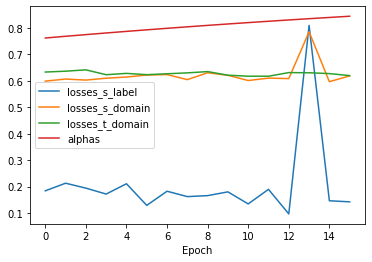

[1/16] class_loss: 0.0980 s_domain_loss: 0.5998 t_domain_loss: 0.6178 aplha: 0.8482836399575131
[2/16] class_loss: 0.1253 s_domain_loss: 0.5775 t_domain_loss: 0.6220 aplha: 0.852607460587903
[3/16] class_loss: 0.1137 s_domain_loss: 0.5968 t_domain_loss: 0.6285 aplha: 0.8568176011108952
[4/16] class_loss: 0.1069 s_domain_loss: 0.5998 t_domain_loss: 0.6109 aplha: 0.8609165109883439
[5/16] class_loss: 0.1397 s_domain_loss: 0.6068 t_domain_loss: 0.6174 aplha: 0.8649066177207418
[6/16] class_loss: 0.1585 s_domain_loss: 0.5906 t_domain_loss: 0.6141 aplha: 0.8687903250818612
[7/16] class_loss: 0.1800 s_domain_loss: 0.5746 t_domain_loss: 0.6164 aplha: 0.8725700114960693
[8/16] class_loss: 0.1801 s_domain_loss: 0.5734 t_domain_loss: 0.6201 aplha: 0.8762480285527146
[9/16] class_loss: 0.1360 s_domain_loss: 0.5816 t_domain_loss: 0.6259 aplha: 0.8798266996519848
[10/16] class_loss: 0.1269 s_domain_loss: 0.5822 t_domain_loss: 0.6107 aplha: 0.883308318776638
[11/16] class_loss: 0.1235 s_domain_loss:

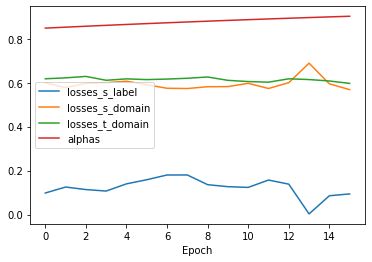

[1/16] class_loss: 0.1387 s_domain_loss: 0.6153 t_domain_loss: 0.5944 aplha: 0.9051482536448667
[2/16] class_loss: 0.1224 s_domain_loss: 0.5600 t_domain_loss: 0.5965 aplha: 0.9079321952015194
[3/16] class_loss: 0.0754 s_domain_loss: 0.5672 t_domain_loss: 0.6011 aplha: 0.9106382594546996
[4/16] class_loss: 0.1059 s_domain_loss: 0.6108 t_domain_loss: 0.5821 aplha: 0.9132684024721864
[5/16] class_loss: 0.0916 s_domain_loss: 0.5851 t_domain_loss: 0.5872 aplha: 0.9158245441687622
[6/16] class_loss: 0.1396 s_domain_loss: 0.5813 t_domain_loss: 0.5837 aplha: 0.9183085681801013
[7/16] class_loss: 0.0962 s_domain_loss: 0.6043 t_domain_loss: 0.5861 aplha: 0.92072232179806
[8/16] class_loss: 0.1143 s_domain_loss: 0.5616 t_domain_loss: 0.5902 aplha: 0.9230676159633513
[9/16] class_loss: 0.1307 s_domain_loss: 0.5622 t_domain_loss: 0.5974 aplha: 0.9253462253117413
[10/16] class_loss: 0.0576 s_domain_loss: 0.5730 t_domain_loss: 0.5835 aplha: 0.9275598882700506
[11/16] class_loss: 0.1124 s_domain_loss:

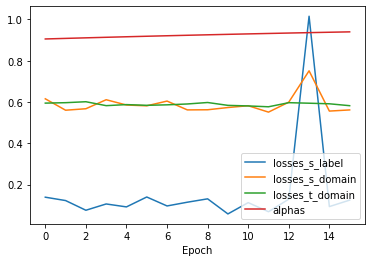

[1/16] class_loss: 0.0667 s_domain_loss: 0.5542 t_domain_loss: 0.5850 aplha: 0.9413755384972873
[2/16] class_loss: 0.0884 s_domain_loss: 0.5462 t_domain_loss: 0.5877 aplha: 0.9431279339102947
[3/16] class_loss: 0.0983 s_domain_loss: 0.5562 t_domain_loss: 0.5942 aplha: 0.9448294355464197
[4/16] class_loss: 0.1325 s_domain_loss: 0.5622 t_domain_loss: 0.5751 aplha: 0.9464814336291136
[5/16] class_loss: 0.1175 s_domain_loss: 0.5580 t_domain_loss: 0.5815 aplha: 0.9480852856044062
[6/16] class_loss: 0.0826 s_domain_loss: 0.5484 t_domain_loss: 0.5775 aplha: 0.9496423165987962
[7/16] class_loss: 0.0952 s_domain_loss: 0.5846 t_domain_loss: 0.5786 aplha: 0.9511538198917857
[8/16] class_loss: 0.0703 s_domain_loss: 0.5557 t_domain_loss: 0.5814 aplha: 0.9526210574012512
[9/16] class_loss: 0.1202 s_domain_loss: 0.5345 t_domain_loss: 0.5893 aplha: 0.9540452601799487
[10/16] class_loss: 0.0847 s_domain_loss: 0.5493 t_domain_loss: 0.5740 aplha: 0.9554276289215491
[11/16] class_loss: 0.0913 s_domain_los

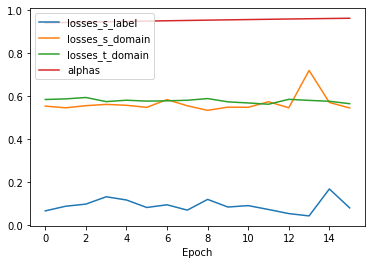

[1/16] class_loss: 0.1362 s_domain_loss: 0.5506 t_domain_loss: 0.5698 aplha: 0.9640275800758169
[2/16] class_loss: 0.0720 s_domain_loss: 0.5532 t_domain_loss: 0.5716 aplha: 0.9651150305275895
[3/16] class_loss: 0.0658 s_domain_loss: 0.5505 t_domain_loss: 0.5776 aplha: 0.9661701734665469
[4/16] class_loss: 0.0658 s_domain_loss: 0.5439 t_domain_loss: 0.5584 aplha: 0.9671939349676739
[5/16] class_loss: 0.0569 s_domain_loss: 0.5583 t_domain_loss: 0.5642 aplha: 0.9681872165763705
[6/16] class_loss: 0.0445 s_domain_loss: 0.5383 t_domain_loss: 0.5607 aplha: 0.9691508958363175
[7/16] class_loss: 0.0498 s_domain_loss: 0.5340 t_domain_loss: 0.5631 aplha: 0.9700858268137
[8/16] class_loss: 0.0979 s_domain_loss: 0.5366 t_domain_loss: 0.5667 aplha: 0.9709928406172359
[9/16] class_loss: 0.0866 s_domain_loss: 0.5278 t_domain_loss: 0.5737 aplha: 0.9718727459135088
[10/16] class_loss: 0.0615 s_domain_loss: 0.5254 t_domain_loss: 0.5584 aplha: 0.9727263294371402
[11/16] class_loss: 0.0743 s_domain_loss: 

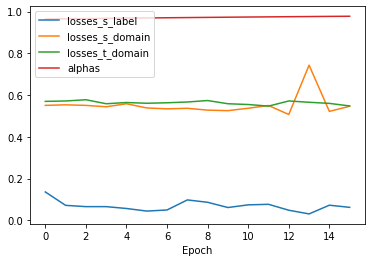

[1/16] class_loss: 0.1003 s_domain_loss: 0.5698 t_domain_loss: 0.5541 aplha: 0.9780261147388136
[2/16] class_loss: 0.0606 s_domain_loss: 0.5456 t_domain_loss: 0.5559 aplha: 0.9786949783205476
[3/16] class_loss: 0.0599 s_domain_loss: 0.5197 t_domain_loss: 0.5622 aplha: 0.9793436949613898
[4/16] class_loss: 0.0803 s_domain_loss: 0.5285 t_domain_loss: 0.5420 aplha: 0.9799728587536536
[5/16] class_loss: 0.0584 s_domain_loss: 0.5083 t_domain_loss: 0.5480 aplha: 0.9805830470370518
[6/16] class_loss: 0.0735 s_domain_loss: 0.4982 t_domain_loss: 0.5445 aplha: 0.9811748208247801
[7/16] class_loss: 0.0741 s_domain_loss: 0.5218 t_domain_loss: 0.5451 aplha: 0.9817487252216388
[8/16] class_loss: 0.0754 s_domain_loss: 0.5823 t_domain_loss: 0.5472 aplha: 0.9823052898341393
[9/16] class_loss: 0.0569 s_domain_loss: 0.5064 t_domain_loss: 0.5558 aplha: 0.9828450291725761
[10/16] class_loss: 0.0595 s_domain_loss: 0.5314 t_domain_loss: 0.5402 aplha: 0.9833684430450518
[11/16] class_loss: 0.0755 s_domain_los

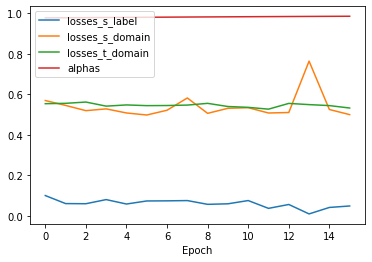

[1/16] class_loss: 0.0599 s_domain_loss: 0.5727 t_domain_loss: 0.5419 aplha: 0.9866142981514305
[2/16] class_loss: 0.0630 s_domain_loss: 0.5128 t_domain_loss: 0.5437 aplha: 0.9870234608066868
[3/16] class_loss: 0.0584 s_domain_loss: 0.4868 t_domain_loss: 0.5504 aplha: 0.987420195726215
[4/16] class_loss: 0.0716 s_domain_loss: 0.5051 t_domain_loss: 0.5289 aplha: 0.9878048756148494
[5/16] class_loss: 0.0444 s_domain_loss: 0.4828 t_domain_loss: 0.5349 aplha: 0.9881778622875124
[6/16] class_loss: 0.0545 s_domain_loss: 0.5114 t_domain_loss: 0.5307 aplha: 0.988539506970016
[7/16] class_loss: 0.0631 s_domain_loss: 0.4886 t_domain_loss: 0.5319 aplha: 0.988890150592618
[8/16] class_loss: 0.0217 s_domain_loss: 0.4864 t_domain_loss: 0.5337 aplha: 0.9892301240764443
[9/16] class_loss: 0.0236 s_domain_loss: 0.4998 t_domain_loss: 0.5417 aplha: 0.9895597486128833
[10/16] class_loss: 0.0697 s_domain_loss: 0.5144 t_domain_loss: 0.5244 aplha: 0.9898793359360678
[11/16] class_loss: 0.0714 s_domain_loss: 

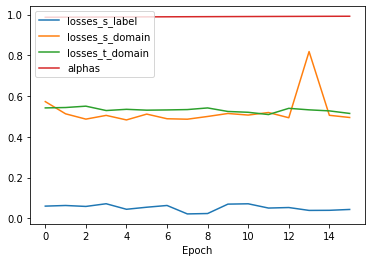

[1/16] class_loss: 0.0596 s_domain_loss: 0.4944 t_domain_loss: 0.5254 aplha: 0.9918597245682079
[2/16] class_loss: 0.0390 s_domain_loss: 0.4778 t_domain_loss: 0.5258 aplha: 0.9921091863867961
[3/16] class_loss: 0.0340 s_domain_loss: 0.5101 t_domain_loss: 0.5312 aplha: 0.9923510327107254
[4/16] class_loss: 0.0543 s_domain_loss: 0.4984 t_domain_loss: 0.5092 aplha: 0.9925854942512276
[5/16] class_loss: 0.0564 s_domain_loss: 0.5052 t_domain_loss: 0.5147 aplha: 0.9928127948371597
[6/16] class_loss: 0.0593 s_domain_loss: 0.5151 t_domain_loss: 0.5115 aplha: 0.9930331516138384
[7/16] class_loss: 0.0489 s_domain_loss: 0.4813 t_domain_loss: 0.5131 aplha: 0.9932467752365213
[8/16] class_loss: 0.0446 s_domain_loss: 0.4968 t_domain_loss: 0.5152 aplha: 0.9934538700586568
[9/16] class_loss: 0.0518 s_domain_loss: 0.5272 t_domain_loss: 0.5248 aplha: 0.9936546343150297
[10/16] class_loss: 0.0443 s_domain_loss: 0.4953 t_domain_loss: 0.5093 aplha: 0.9938492602999036
[11/16] class_loss: 0.0403 s_domain_los

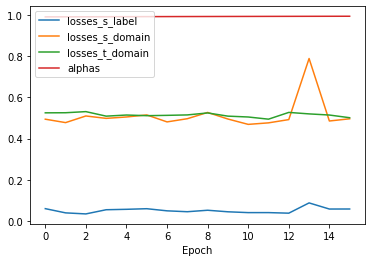

[1/16] class_loss: 0.0412 s_domain_loss: 0.4791 t_domain_loss: 0.5144 aplha: 0.9950547536867307
[2/16] class_loss: 0.0454 s_domain_loss: 0.4438 t_domain_loss: 0.5147 aplha: 0.9952065382597419
[3/16] class_loss: 0.0328 s_domain_loss: 0.4589 t_domain_loss: 0.5208 aplha: 0.9953536749547376
[4/16] class_loss: 0.0476 s_domain_loss: 0.4942 t_domain_loss: 0.4974 aplha: 0.995496305440994
[5/16] class_loss: 0.0438 s_domain_loss: 0.4454 t_domain_loss: 0.5028 aplha: 0.9956345671093094
[6/16] class_loss: 0.0294 s_domain_loss: 0.4657 t_domain_loss: 0.4987 aplha: 0.9957685931988136
[7/16] class_loss: 0.0160 s_domain_loss: 0.4801 t_domain_loss: 0.4993 aplha: 0.9958985129201652
[8/16] class_loss: 0.0595 s_domain_loss: 0.5490 t_domain_loss: 0.4997 aplha: 0.9960244515752319
[9/16] class_loss: 0.0385 s_domain_loss: 0.4630 t_domain_loss: 0.5105 aplha: 0.996146530673345
[10/16] class_loss: 0.0537 s_domain_loss: 0.4797 t_domain_loss: 0.4939 aplha: 0.9962648680442134
[11/16] class_loss: 0.0197 s_domain_loss:

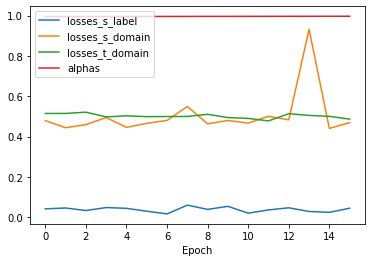

[1/16] class_loss: 0.0490 s_domain_loss: 0.4949 t_domain_loss: 0.5004 aplha: 0.996997635486526
[2/16] class_loss: 0.0587 s_domain_loss: 0.4736 t_domain_loss: 0.5004 aplha: 0.9970898741229344
[3/16] class_loss: 0.0333 s_domain_loss: 0.4489 t_domain_loss: 0.5074 aplha: 0.9971792830067638
[4/16] class_loss: 0.0415 s_domain_loss: 0.5041 t_domain_loss: 0.4841 aplha: 0.9972659487086875
[5/16] class_loss: 0.0226 s_domain_loss: 0.4890 t_domain_loss: 0.4905 aplha: 0.9973499551655736
[6/16] class_loss: 0.0299 s_domain_loss: 0.4562 t_domain_loss: 0.4880 aplha: 0.9974313837597322
[7/16] class_loss: 0.0377 s_domain_loss: 0.4496 t_domain_loss: 0.4903 aplha: 0.9975103133958232
[8/16] class_loss: 0.0335 s_domain_loss: 0.4408 t_domain_loss: 0.4917 aplha: 0.9975868205755074
[9/16] class_loss: 0.0623 s_domain_loss: 0.4298 t_domain_loss: 0.5016 aplha: 0.997660979469889
[10/16] class_loss: 0.0423 s_domain_loss: 0.4803 t_domain_loss: 0.4835 aplha: 0.9977328619898251
[11/16] class_loss: 0.0489 s_domain_loss:

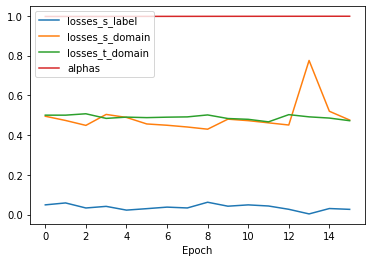

[1/16] class_loss: 0.0325 s_domain_loss: 0.4554 t_domain_loss: 0.4882 aplha: 0.9981778976111988
[2/16] class_loss: 0.0264 s_domain_loss: 0.4372 t_domain_loss: 0.4876 aplha: 0.9982339083044309
[3/16] class_loss: 0.0484 s_domain_loss: 0.4655 t_domain_loss: 0.4945 aplha: 0.9982881987265098
[4/16] class_loss: 0.0361 s_domain_loss: 0.4539 t_domain_loss: 0.4711 aplha: 0.9983408216232819
[5/16] class_loss: 0.0263 s_domain_loss: 0.4345 t_domain_loss: 0.4771 aplha: 0.9983918281287416
[6/16] class_loss: 0.0476 s_domain_loss: 0.4521 t_domain_loss: 0.4739 aplha: 0.9984412678139583
[7/16] class_loss: 0.0519 s_domain_loss: 0.4475 t_domain_loss: 0.4753 aplha: 0.9984891887345411
[8/16] class_loss: 0.0223 s_domain_loss: 0.4612 t_domain_loss: 0.4754 aplha: 0.9985356374766783
[9/16] class_loss: 0.0208 s_domain_loss: 0.4779 t_domain_loss: 0.4870 aplha: 0.998580659201799
[10/16] class_loss: 0.0513 s_domain_loss: 0.4301 t_domain_loss: 0.4706 aplha: 0.9986242976898896
[11/16] class_loss: 0.0334 s_domain_loss

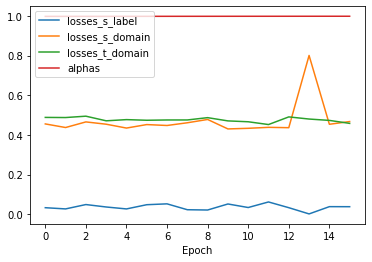

[1/16] class_loss: 0.0164 s_domain_loss: 0.4399 t_domain_loss: 0.4750 aplha: 0.9988944427261528
[2/16] class_loss: 0.0348 s_domain_loss: 0.4321 t_domain_loss: 0.4733 aplha: 0.9989284389233053
[3/16] class_loss: 0.0217 s_domain_loss: 0.4388 t_domain_loss: 0.4789 aplha: 0.9989613902710099
[4/16] class_loss: 0.0095 s_domain_loss: 0.4445 t_domain_loss: 0.4532 aplha: 0.9989933288490944
[5/16] class_loss: 0.0289 s_domain_loss: 0.4107 t_domain_loss: 0.4591 aplha: 0.9990242857544356
[6/16] class_loss: 0.0384 s_domain_loss: 0.4077 t_domain_loss: 0.4547 aplha: 0.9990542911309594
[7/16] class_loss: 0.0276 s_domain_loss: 0.4653 t_domain_loss: 0.4555 aplha: 0.99908337419873
[8/16] class_loss: 0.0504 s_domain_loss: 0.4602 t_domain_loss: 0.4549 aplha: 0.999111563282157
[9/16] class_loss: 0.0101 s_domain_loss: 0.4562 t_domain_loss: 0.4660 aplha: 0.9991388858373509
[10/16] class_loss: 0.0183 s_domain_loss: 0.4432 t_domain_loss: 0.4491 aplha: 0.9991653684786446
[11/16] class_loss: 0.0496 s_domain_loss: 

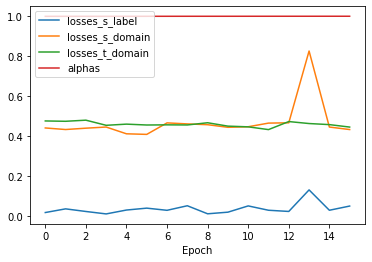

[1/16] class_loss: 0.0297 s_domain_loss: 0.4063 t_domain_loss: 0.4647 aplha: 0.9993292997390673
[2/16] class_loss: 0.0240 s_domain_loss: 0.4274 t_domain_loss: 0.4645 aplha: 0.9993499283095266
[3/16] class_loss: 0.0180 s_domain_loss: 0.4339 t_domain_loss: 0.4717 aplha: 0.9993699226118375
[4/16] class_loss: 0.0405 s_domain_loss: 0.4312 t_domain_loss: 0.4460 aplha: 0.999389302135776
[5/16] class_loss: 0.0247 s_domain_loss: 0.4465 t_domain_loss: 0.4529 aplha: 0.9994080857729739
[6/16] class_loss: 0.0231 s_domain_loss: 0.3967 t_domain_loss: 0.4504 aplha: 0.999426291835225
[7/16] class_loss: 0.0398 s_domain_loss: 0.4525 t_domain_loss: 0.4529 aplha: 0.9994439380722449
[8/16] class_loss: 0.0378 s_domain_loss: 0.4184 t_domain_loss: 0.4530 aplha: 0.9994610416888825
[9/16] class_loss: 0.0207 s_domain_loss: 0.4271 t_domain_loss: 0.4663 aplha: 0.9994776193618087
[10/16] class_loss: 0.0222 s_domain_loss: 0.4111 t_domain_loss: 0.4485 aplha: 0.9994936872556979
[11/16] class_loss: 0.0203 s_domain_loss:

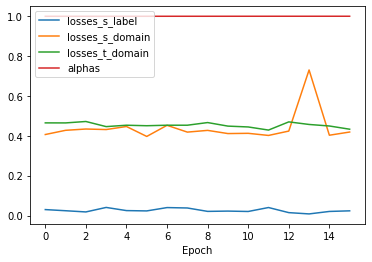

[1/16] class_loss: 0.0172 s_domain_loss: 0.3981 t_domain_loss: 0.4514 aplha: 0.9995931460438896
[2/16] class_loss: 0.0206 s_domain_loss: 0.4284 t_domain_loss: 0.4484 aplha: 0.9996056611560755
[3/16] class_loss: 0.0301 s_domain_loss: 0.4741 t_domain_loss: 0.4537 aplha: 0.9996177913682447
[4/16] class_loss: 0.0107 s_domain_loss: 0.3827 t_domain_loss: 0.4273 aplha: 0.9996295485134694
[5/16] class_loss: 0.0216 s_domain_loss: 0.3984 t_domain_loss: 0.4326 aplha: 0.9996409440613065
[6/16] class_loss: 0.0455 s_domain_loss: 0.3936 t_domain_loss: 0.4289 aplha: 0.9996519891289457
[7/16] class_loss: 0.0196 s_domain_loss: 0.4149 t_domain_loss: 0.4302 aplha: 0.9996626944920217
[8/16] class_loss: 0.0149 s_domain_loss: 0.3616 t_domain_loss: 0.4287 aplha: 0.9996730705950918
[9/16] class_loss: 0.0279 s_domain_loss: 0.4051 t_domain_loss: 0.4405 aplha: 0.999683127561795
[10/16] class_loss: 0.0182 s_domain_loss: 0.4225 t_domain_loss: 0.4219 aplha: 0.9996928752047007
[11/16] class_loss: 0.0235 s_domain_loss

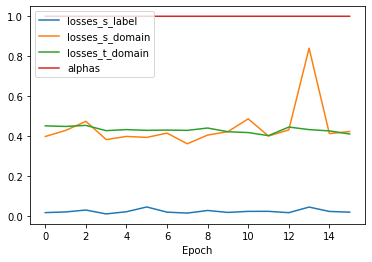

[1/16] class_loss: 0.0178 s_domain_loss: 0.3725 t_domain_loss: 0.4319 aplha: 0.9997532108480274
[2/16] class_loss: 0.0278 s_domain_loss: 0.4130 t_domain_loss: 0.4299 aplha: 0.9997608028438996
[3/16] class_loss: 0.0150 s_domain_loss: 0.4135 t_domain_loss: 0.4368 aplha: 0.9997681613136271
[4/16] class_loss: 0.0271 s_domain_loss: 0.3745 t_domain_loss: 0.4086 aplha: 0.9997752934387225
[5/16] class_loss: 0.0236 s_domain_loss: 0.4697 t_domain_loss: 0.4157 aplha: 0.9997822061799468
[6/16] class_loss: 0.0212 s_domain_loss: 0.4495 t_domain_loss: 0.4136 aplha: 0.9997889062840914
[7/16] class_loss: 0.0236 s_domain_loss: 0.3810 t_domain_loss: 0.4168 aplha: 0.9997954002905483
[8/16] class_loss: 0.0297 s_domain_loss: 0.4233 t_domain_loss: 0.4156 aplha: 0.9998016945376818
[9/16] class_loss: 0.0214 s_domain_loss: 0.3900 t_domain_loss: 0.4324 aplha: 0.999807795169001
[10/16] class_loss: 0.0235 s_domain_loss: 0.3976 t_domain_loss: 0.4159 aplha: 0.9998137081391485
[11/16] class_loss: 0.0368 s_domain_loss

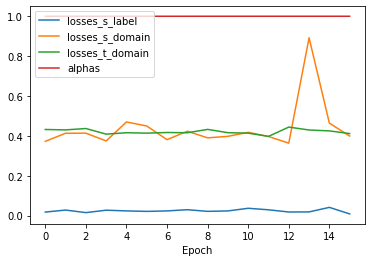

[1/16] class_loss: 0.0189 s_domain_loss: 0.3698 t_domain_loss: 0.4348 aplha: 0.999850307544979
[2/16] class_loss: 0.0145 s_domain_loss: 0.3859 t_domain_loss: 0.4322 aplha: 0.9998549127635394
[3/16] class_loss: 0.0302 s_domain_loss: 0.3835 t_domain_loss: 0.4386 aplha: 0.9998593763146617
[4/16] class_loss: 0.0119 s_domain_loss: 0.3783 t_domain_loss: 0.4113 aplha: 0.9998637025557675
[5/16] class_loss: 0.0254 s_domain_loss: 0.3536 t_domain_loss: 0.4184 aplha: 0.9998678957102909
[6/16] class_loss: 0.0210 s_domain_loss: 0.3931 t_domain_loss: 0.4156 aplha: 0.9998719598717924
[7/16] class_loss: 0.0120 s_domain_loss: 0.4016 t_domain_loss: 0.4184 aplha: 0.9998758990079541
[8/16] class_loss: 0.0290 s_domain_loss: 0.3780 t_domain_loss: 0.4181 aplha: 0.9998797169644462
[9/16] class_loss: 0.0190 s_domain_loss: 0.3649 t_domain_loss: 0.4337 aplha: 0.9998834174686777
[10/16] class_loss: 0.0249 s_domain_loss: 0.3888 t_domain_loss: 0.4173 aplha: 0.9998870041334327
[11/16] class_loss: 0.0186 s_domain_loss

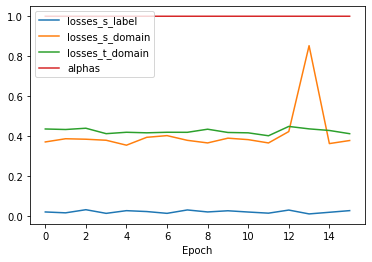

In [19]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
running_corrects = 0
current_step = 0
# Start iterating over the epochs
# Iterate over the dataset

for epoch in range(NUM_EPOCHS):
  scheduler.step() 
  iterPh = iter(photos_dataloader)
  iterAP = iter(art_painting_dataloader)
  losses = []
  alphas = []
  for batch in range(max_batches):
    net.train() # Sets module in training mode
    optimizer.zero_grad() # Zero-ing the gradients
    if( batch == min_batches):
      iterPh = iter(photos_dataloader)
    images_source, labels_source = next(iterPh)
    labels_domain = torch.zeros(len(images_source), dtype=torch.long)

    p = float(batch + epoch * max_batches) / (NUM_EPOCHS * max_batches)
    alfa = 2. / (1. + np.exp(-10 * p)) - 1
    
    # Bring data over the device of choice
    images_source = images_source.to(DEVICE)
    labels_source = labels_source.to(DEVICE)
    labels_domain = labels_domain.to(DEVICE)

  
    # Get the output for classes and domains; class_pred, domain_pred
    classes_output = net(images_source)
    # Compute the loss on the source domain
    loss_s_label = criterion_class(classes_output, labels_source)

    domain_output = net(images_source, alfa)
    # Compute the loss on the source domain
    loss_s_domain = criterion_domain(domain_output, labels_domain)

    # Get the output for targets
    targets, _ = next(iterAP)
    target_domain = torch.ones(len(targets), dtype=torch.long)

    # Bring data over the device of choice
    targets = targets.to(DEVICE)
    target_domain = target_domain.to(DEVICE)

    target_output = net(targets, alfa)
    # Compute the loss on the source domain
    loss_t_domain = criterion_domain(target_output,target_domain)

    loss = loss_s_label + loss_s_domain + loss_t_domain
    loss.backward()  # backward pass: computes gradients
    losses.append( (loss_s_label, loss_s_domain, loss_t_domain))
    alphas.append(alfa)
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

    print(f'[{batch+1}/{max_batches}] '
          f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
          f't_domain_loss: {loss_t_domain.item():.4f} '
          f'aplha: {alfa}'
          )  
  torch.save(net, 'model_epoch_{0}.pt'.format(epoch))
  testFunction('photo', epoch)
  testFunction('artPainting', epoch)
  plotfunction(losses, alphas)
  

In [20]:
LR

1e-05

In [21]:
alfa

0.9999063222315012